# Tutorial

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os


from core.losses import CustomMSE, ASTROMERLoss, CustomBCE
from core.plot import plot_lc, plot_input_layer
from core.callbacks import get_callbacks
from core.transformer import ASTROMER
from core.metrics import CustomACC
from core.input import InputLayer
from core.data  import (create_dataset, 
                        load_records)

%load_ext autoreload
%autoreload 2

In [2]:
source = './data/raw_data/macho/MACHO/LCs' # lightcurves folder
metadata = 'data/raw_data/macho/MACHO/MACHO_dataset.dat' # metadata file
target = 'data/records/macho/' # where records will be stored

### Metadata frame sample

In [3]:
meta_sample = pd.read_csv(metadata).sample(1)
meta_sample

,Class,N,Path,Band
15,RRL,1128,lc_2_4909_905_B_mjd.dat,B


### Lightcurve frame sample

In [4]:
lc_df = pd.read_csv(os.path.join(source,  meta_sample['Path'].values[0]))
lc_df.head()

,mjd,mag,errmag
0,48823.668380,-5.658,0.519
1,48824.495451,-4.383,1.128
2,48825.513079,-5.079,0.941
3,48828.460231,-5.425,0.100
4,48829.467095,-4.876,0.061


### From .csv to .record 

In [5]:
create_dataset(source, metadata, target, max_lcs_per_record=1000)

100%|██████████| 7/7 [00:09<00:00,  1.34s/it]


### Visualizing Records

In [6]:
input_len = 100 # maximum lightcurve length
batch_size = 10
dataset = load_records(target+'/train', batch_size=batch_size, input_len=input_len)

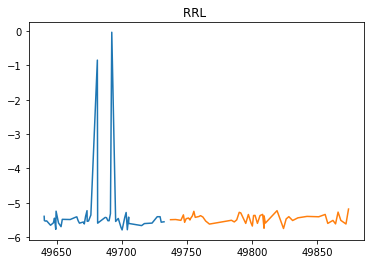

In [7]:
fig, axes = plt.subplots(1,1)
for batch in dataset:
    plot_lc(batch, axes, target, n=0)
    break

## ASTROMER

### Input Layer

In [8]:
inp_layer = InputLayer()

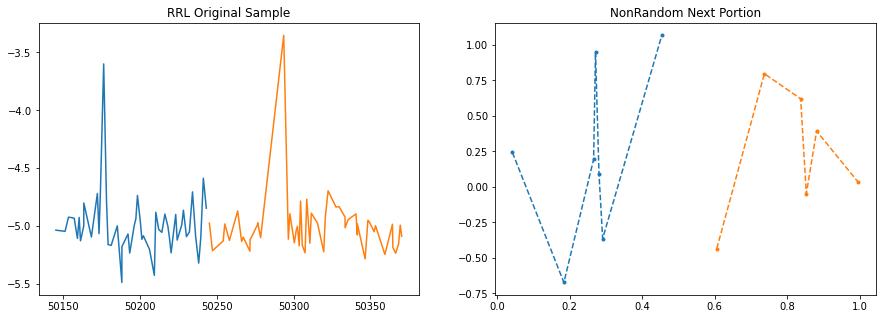

In [9]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
for batch in dataset:
    n = 0
    plot_lc(batch, axes[0], target, n=0, title='Original Sample')
    # Input transformation
    in_dict = inp_layer(batch)    
    
    plot_input_layer(in_dict, axes[1], input_len, n=0)
    break

### Training

In [10]:
exp_save = './experiments/macho_v1' # folder to save weigths and tensorboard logs

In [11]:
# Loading data
train_batches = load_records(os.path.join(target, 'train'), 
                             batch_size, 
                             input_len=input_len)
valid_batches = load_records(os.path.join(target, 'val'), 
                             batch_size, 
                             input_len=input_len)
test_batches = load_records(os.path.join(target, 'test'), 
                             batch_size, 
                             input_len=input_len)

In [12]:
# Model Instance
transformer = ASTROMER(num_layers=2, # Number of self-attention layers
                       d_model=1628, # attention dimensionality (should be divisor of num_heads)
                       num_heads=4,# Number of self-attention heads
                       dff=1024, # Dimensionality of the middle  dense layer at the end of the encoder
                       rate=0.1, # Dropout rate
                       base=10000, # Base for positional encoder
                       mask_frac=0.15, # fraction of the total to be masked
                       npp_frac=0.5, # next portion prediction rate
                       rand_frac=0.1, # 'rand_frac' of the 'mask_frac' to change [MASK] by random magnitudes
                       same_frac=0.1, # 'same_frac' of the 'mask_frac' to change [MASK] by current magnitudes
                       sep_token=102., # end of sequence token
                       cls_token=101.) # NPP class token

In [13]:
# Optimizer
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)
# Model Instance
# Compile
transformer.compile(optimizer=optimizer,
                    loss=ASTROMERLoss(),
                    metrics=[CustomMSE(), CustomBCE(), CustomACC()])
# Create graph
transformer.model(batch_size).summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Serie1 (InputLayer)             [(10, 50, 3)]        0                                            
__________________________________________________________________________________________________
Serie2 (InputLayer)             [(10, 50, 3)]        0                                            
__________________________________________________________________________________________________
steps_1 (InputLayer)            [(10,)]              0                                            
__________________________________________________________________________________________________
steps_2 (InputLayer)            [(10,)]              0                                            
______________________________________________________________________________________________

In [14]:
%%time
# Training
transformer.fit(train_batches.take(1),
                epochs=1,
                verbose=1,
                validation_data=valid_batches.take(1),
                callbacks=get_callbacks(exp_save))

1/1 [==============================] - 8s 8s/step - loss: 12.4591 - MSE: 12.1279 - BCE: 0.3312 - Accuracy: 0.9000 - val_loss: 3680.2649 - val_MSE: 3668.1968 - val_BCE: 12.0680 - val_Accuracy: 0.5000
CPU times: user 18.7 s, sys: 956 ms, total: 19.6 s
Wall time: 12.6 s


In [15]:
# Testing
metrics = transformer.evaluate(test_batches)

2/2 [==============================] - 1s 64ms/step - loss: 1290.5924 - MSE: 1514.2793 - BCE: 14.0307 - Accuracy: 0.4167
